In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thesis-data/Nebuli_data.csv
/kaggle/input/thesis-data/preprocessed_nlp_data.csv


In [2]:
!pip install --upgrade nltk
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 37.0 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819467 sha256=557a9f3b86ca2b17e7b09ab350cccb6f691405124fffe9e994344d1c3b56ed11
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76

In [3]:
import pandas as pd
import numpy as np
from plotly import graph_objs as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer, PorterStemmer
# from sklearn.feature_extraction.text import TfidfVectorizer
# dler = nltk.downloader.Downloader()
# dler._update_index()
nltk.data.path.append('/kaggle/output')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.corpus import  wordnet

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data_df = pd.read_csv('/kaggle/input/thesis-data/Nebuli_data.csv',index_col=0)
data_df.head()


,id,title,introtext,fulltext,cat_id,class_2,level,cat_parent_id,parent_title,grandparent_id,grandparent_title
0,201,SGI Launches Open Storage Initiative,Silicon Graphics has today announced the Open ...,Silicon Graphics has today announced the Open ...,1836,Data Management,3,2100,Big Data,2096,Channels
1,270,IBM Releases Next Generation Storage Virtualis...,IBM has revealed its TotalStorage SAN File Sys...,IBM has revealed its TotalStorage SAN File Sys...,1836,Data Management,3,2100,Big Data,2096,Channels
2,293,IBM Launches New Mainframe and Storage Systems...,Celebrating the 40th anniversary of the IBM Sy...,Celebrating the 40th anniversary of the IBM S...,1836,Data Management,3,2100,Big Data,2096,Channels
3,337,Oracle 10g database sets the pace for a world ...,Oracle is setting the pace for the highest per...,Tests were performed on an eight-node cluster...,1836,Data Management,3,2100,Big Data,2096,Channels
4,339,IBM Releases New Automated DB2 Database Software,IBM has today announced the release of its new...,The new database software promises to deliver...,1836,Data Management,3,2100,Big Data,2096,Channels


In [5]:
len(data_df.id.unique())

9413

In [6]:
data_df.isnull().sum()

id                     0
title                  0
introtext            378
fulltext             259
cat_id                 0
class_2                0
level                  0
cat_parent_id          0
parent_title           0
grandparent_id         0
grandparent_title      0
dtype: int64

In [7]:
data_df = data_df[data_df['fulltext'].isnull()==False]
len(data_df[data_df.isnull()==False])

9154

In [8]:
data_df.isnull().sum()

id                     0
title                  0
introtext            378
fulltext               0
cat_id                 0
class_2                0
level                  0
cat_parent_id          0
parent_title           0
grandparent_id         0
grandparent_title      0
dtype: int64

In [9]:
k = data_df.groupby(['parent_title']).agg({'id':'count'}).reset_index()
fig = px.bar(k, y="parent_title",x='id')
fig.show()

In [10]:
data_df.loc[data_df['parent_title'] == 'Channels', 'parent_title'] = data_df['class_2']
data_df.loc[data_df['cat_parent_id'] == '2096', 'cat_parent_id'] = data_df['cat_id']
data_df.parent_title.unique(),len(data_df.parent_title.unique())

(array(['Big Data', 'Nanotechnology', 'Alternative Energy', 'Bio-IT',
        'Healthcare Technology', 'Genomics', 'Clinical Research',
        'Disease Processes', 'Cancer Research', 'Bioengineering',
        'Green Biology', 'Proteomics', 'Stem Cells', 'Neuroscience',
        'Material Science', 'Cell Biology', 'Food Bioscience',
        'Biopollution', 'Social Science', 'Astrobiology'], dtype=object),
 20)

In [11]:
k = data_df.groupby(['parent_title']).agg({'id':'count'}).reset_index()
k = k[k['id']>50]
fig = px.bar(k, y="parent_title",x='id')
data_df = data_df[data_df['parent_title'].isin(k.parent_title.unique())]
fig.show()

In [12]:
data_df.parent_title.unique(),len(data_df.parent_title.unique())

(array(['Big Data', 'Nanotechnology', 'Alternative Energy', 'Bio-IT',
        'Healthcare Technology', 'Genomics', 'Clinical Research',
        'Disease Processes', 'Cancer Research', 'Bioengineering',
        'Green Biology', 'Proteomics', 'Stem Cells', 'Neuroscience',
        'Material Science', 'Cell Biology', 'Food Bioscience',
        'Biopollution'], dtype=object),
 18)

In [13]:
def preprocess_text(text):
    # Tokenization
    text= ''.join(e for e in text if e.isalnum() or e in {' ','\n'})
    tokens = nltk.word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
#     lemmatizer = WordNetLemmatizer()
#     tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [PorterStemmer().stem(token) for token in tokens]
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

data_df['title_cleaned'] = data_df['title'].apply(preprocess_text)
data_df['introtext'] = data_df['introtext'].astype(str)
data_df['introtext_cleaned'] =data_df['introtext'].apply(preprocess_text)
data_df['fulltext'] = data_df['fulltext'].astype(str)
data_df['fulltext_cleaned'] =data_df['fulltext'].apply(preprocess_text)
data_df.to_csv('preprocessed_nlp_data.csv')
data_df.head()

,id,title,introtext,fulltext,cat_id,class_2,level,cat_parent_id,parent_title,grandparent_id,grandparent_title,title_cleaned,introtext_cleaned,fulltext_cleaned
0,201,SGI Launches Open Storage Initiative,Silicon Graphics has today announced the Open ...,Silicon Graphics has today announced the Open ...,1836,Data Management,3,2100,Big Data,2096,Channels,sgi launch open storag initi,silicon graphic today announc open storag init...,silicon graphic today announc open storag init...
1,270,IBM Releases Next Generation Storage Virtualis...,IBM has revealed its TotalStorage SAN File Sys...,IBM has revealed its TotalStorage SAN File Sys...,1836,Data Management,3,2100,Big Data,2096,Channels,ibm releas next gener storag virtualis softwar...,ibm reveal totalstorag san file system softwar...,ibm reveal totalstorag san file system softwar...
2,293,IBM Launches New Mainframe and Storage Systems...,Celebrating the 40th anniversary of the IBM Sy...,Celebrating the 40th anniversary of the IBM S...,1836,Data Management,3,2100,Big Data,2096,Channels,ibm launch new mainfram storag system celebr 4...,celebr 40th anniversari ibm system360 mainfram...,celebr 40th anniversari ibm system360 mainfram...
3,337,Oracle 10g database sets the pace for a world ...,Oracle is setting the pace for the highest per...,Tests were performed on an eight-node cluster...,1836,Data Management,3,2100,Big Data,2096,Channels,oracl 10g databas set pace world record perform,oracl set pace highest perform oracl databas 1...,test perform eightnod cluster industrystandard...
4,339,IBM Releases New Automated DB2 Database Software,IBM has today announced the release of its new...,The new database software promises to deliver...,1836,Data Management,3,2100,Big Data,2096,Channels,ibm releas new autom db2 databas softwar,ibm today announc releas new db2 univers datab...,new databas softwar promis deliv number key im...


In [14]:
data_df = data_df.reset_index(drop=True)
len(data_df)

9150

In [15]:
nlp_df = pd.read_csv('/kaggle/input/thesis-data/preprocessed_nlp_data.csv',index_col=0)
nlp_df.head() 

,id,title,introtext,fulltext,cat_id,class_2,level,cat_parent_id,parent_title,grandparent_id,grandparent_title,title_cleaned,introtext_cleaned,fulltext_cleaned
0,201,SGI Launches Open Storage Initiative,Silicon Graphics has today announced the Open ...,Silicon Graphics has today announced the Open ...,1836,Data Management,3,2100,Big Data,2096,Channels,sgi launch open storag initi,silicon graphic today announc open storag init...,silicon graphic today announc open storag init...
1,270,IBM Releases Next Generation Storage Virtualis...,IBM has revealed its TotalStorage SAN File Sys...,IBM has revealed its TotalStorage SAN File Sys...,1836,Data Management,3,2100,Big Data,2096,Channels,ibm releas next gener storag virtualis softwar...,ibm reveal totalstorag san file system softwar...,ibm reveal totalstorag san file system softwar...
2,293,IBM Launches New Mainframe and Storage Systems...,Celebrating the 40th anniversary of the IBM Sy...,Celebrating the 40th anniversary of the IBM S...,1836,Data Management,3,2100,Big Data,2096,Channels,ibm launch new mainfram storag system celebr 4...,celebr 40th anniversari ibm system360 mainfram...,celebr 40th anniversari ibm system360 mainfram...
3,337,Oracle 10g database sets the pace for a world ...,Oracle is setting the pace for the highest per...,Tests were performed on an eight-node cluster...,1836,Data Management,3,2100,Big Data,2096,Channels,oracl 10g databas set pace world record perform,oracl set pace highest perform oracl databas 1...,test perform eightnod cluster industrystandard...
4,339,IBM Releases New Automated DB2 Database Software,IBM has today announced the release of its new...,The new database software promises to deliver...,1836,Data Management,3,2100,Big Data,2096,Channels,ibm releas new autom db2 databas softwar,ibm today announc releas new db2 univers datab...,new databas softwar promis deliv number key im...


In [16]:
feature_names_list = []
bag_nlp_df = data_df.copy(deep=True)
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(bag_nlp_df['fulltext_cleaned'].values.astype('U'))
feature_names = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
bag_nlp_df = pd.concat([bag_nlp_df, bow_df], axis=1)
feature_names_list.extend(feature_names)
bag_nlp_df.tail()

,id,title,introtext,fulltext,cat_id,class_2,level,cat_parent_id,parent_title,grandparent_id,...,ãsa,ãscar,ãse,ãsecretase1,ãslaug,ãthe,ãverkalix,ãystein,ãzer,ãzge
9145,9482,Researchers Revealed New Method for Making Ela...,"Stockholm, Sweden (Scicasts) Â A method for m...",Using nanocellulose broken down from tree fib...,2139,Battery Energy,3,2128,Alternative Energy,2096,...,0,0,0,0,0,0,0,0,0,0
9146,9515,Origami Used to Create Battery,"Binghamton, NY (Scicasts) Â Origami, the Japa...","Seokheun Sean Choi developed an inexpensive, ...",2139,Battery Energy,3,2128,Alternative Energy,2096,...,0,0,0,0,0,0,0,0,0,0
9147,10957,"Researchers Are a Step Closer Towards New, Fas...","Washington, DC (Scicasts) Â Researchers found...","In this research, the internal gaps in the...",2139,Battery Energy,3,2128,Alternative Energy,2096,...,0,0,0,0,0,0,0,0,0,0
9148,3568,Scientists Invent iMobot,"Davis, CA (Scicasts) Â Scientists at the Univ...",Graham Ryland and Professor Harry Cheng hope ...,2149,Biorobotics,3,2093,Bioengineering,2096,...,0,0,0,0,0,0,0,0,0,0
9149,10963,Research Brings 'Smart Hands' Closer to Reality,"Brighton, UK (Scicasts) Â Using your skin as ...",The University of Sussex-led study - fund...,2149,Biorobotics,3,2093,Bioengineering,2096,...,0,0,0,0,0,0,0,0,0,0


In [17]:
len(bow_df)

9150

In [18]:
df_bow_sklearn = pd.DataFrame(bag_of_words.toarray(),columns=feature_names)

8089


(array([1.06027e+05, 2.77000e+02, 1.09000e+02, 4.80000e+01, 3.20000e+01,
        1.10000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([1.0000e+00, 8.0980e+02, 1.6186e+03, 2.4274e+03, 3.2362e+03,
        4.0450e+03, 4.8538e+03, 5.6626e+03, 6.4714e+03, 7.2802e+03,
        8.0890e+03]),
 <BarContainer object of 10 artists>)

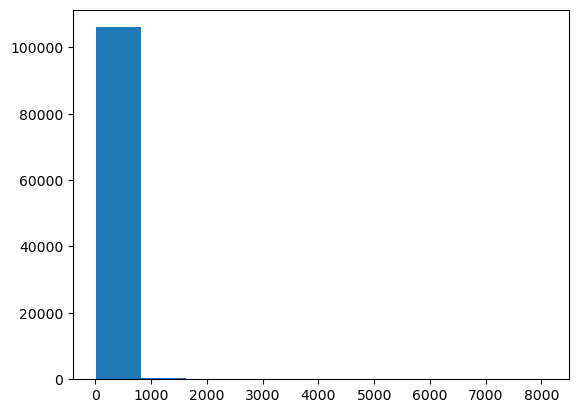

In [19]:
print(max(df_bow_sklearn.astype('bool').sum()))
series = df_bow_sklearn.astype('bool').sum(axis=0)
plt.hist(series)

(array([786., 181.,  98.,  42.,  27.,  23.,   9.,   4.,   2.,   3.]),
 array([ 300.,  979., 1658., 2337., 3016., 3695., 4374., 5053., 5732.,
        6411., 7090.]),
 <BarContainer object of 10 artists>)

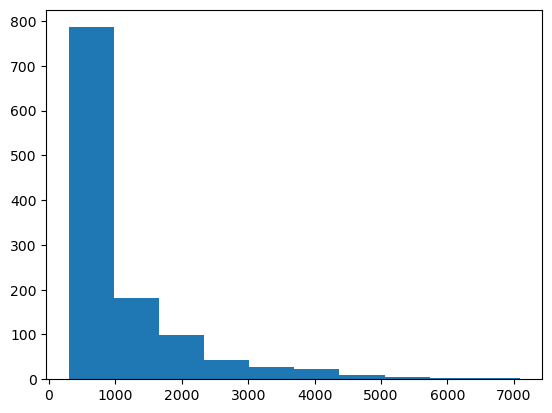

In [20]:
df_bow_sklearn = df_bow_sklearn.loc[:, (df_bow_sklearn.astype('bool').sum() >= 300) & (df_bow_sklearn.astype('bool').sum() <= 8000)]
df_bow_sklearn = df_bow_sklearn.loc[:, ~df_bow_sklearn.columns.str.contains(r'\d')]
series = df_bow_sklearn.astype('bool').sum(axis=0)
plt.hist(series)

In [21]:
df_bow_sklearn.shape,bag_nlp_df.shape

((9150, 1175), (9150, 106532))

In [22]:
df_bow_sklearn.head()

,abil,abl,abnorm,academi,acceler,access,accord,account,accumul,accur,...,year,yet,yield,young,âin,âit,âour,âthe,âthi,âwe
0,0,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
bag_nlp_df = pd.concat([data_df[['cat_id','cat_parent_id','grandparent_id']], df_bow_sklearn], axis=1)
bag_nlp_df.shape

(9150, 1178)

In [24]:
bag_nlp_df.tail()

,cat_id,cat_parent_id,grandparent_id,abil,abl,abnorm,academi,acceler,access,accord,...,year,yet,yield,young,âin,âit,âour,âthe,âthi,âwe
9145,2139,2128,2096,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9146,2139,2128,2096,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9147,2139,2128,2096,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9148,2149,2093,2096,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9149,2149,2093,2096,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
bag_nlp_df.to_csv('temp.csv')

In [26]:
bag_nlp_df.isnull().sum()

cat_id            0
cat_parent_id     0
grandparent_id    0
abil              0
abl               0
                 ..
âit               0
âour              0
âthe              0
âthi              0
âwe               0
Length: 1178, dtype: int64

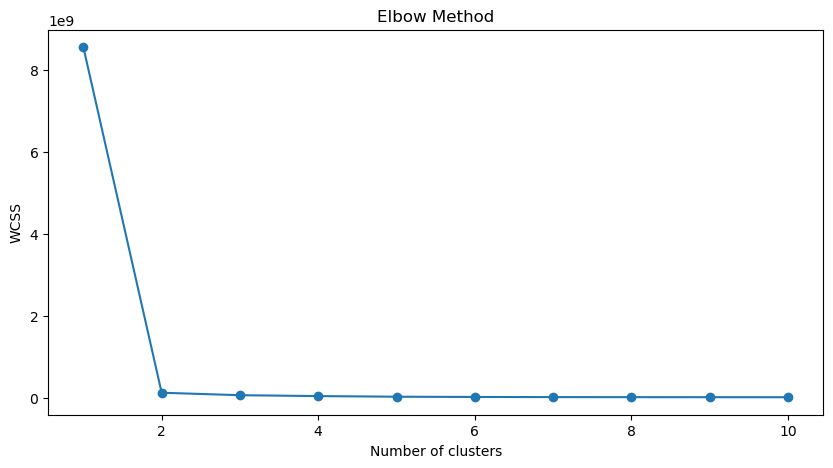

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
X = bag_nlp_df
wcss = []
K_range = range(1, 11)
for i in K_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10,5))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [28]:
import numpy as np
import plotly.express as px
from sklearn import datasets
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
import hdbscan

n_samples = 1500
random_state = 170
X = bag_nlp_df

methods = {
    "KMeans": KMeans(n_clusters=2),
    "SpectralClustering": SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans'),
    "Hierarchical": AgglomerativeClustering(n_clusters=2),
    "DBSCAN": DBSCAN(eps=0.1),
    "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=2)
}

results = {}

for name, method in methods.items():
    results[name] = method.fit_predict(X)
    
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_data = tsne.fit_transform(X)

for name, labels in results.items():
    fig = px.scatter(reduced_data, color=labels, title=name)
    fig.show()


In [29]:
reduced_data

array([[-50.10574 , -43.638157],
       [-50.13509 , -43.600002],
       [-50.14473 , -43.660374],
       ...,
       [ -5.719945,  71.394226],
       [-17.405396,  59.8661  ],
       [-17.406738,  59.86501 ]], dtype=float32)

In [30]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
silhouette = silhouette_score(reduced_data, results['KMeans'])
davies_bouldin = davies_bouldin_score(reduced_data,results['KMeans'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['KMeans'])

silhouette,davies_bouldin, calinski_harabasz

(0.08819828, 2.841245520698573, 778.4942210546012)

In [31]:
silhouette = silhouette_score(reduced_data, results['SpectralClustering'])
davies_bouldin = davies_bouldin_score(reduced_data,results['SpectralClustering'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['SpectralClustering'])

silhouette,davies_bouldin, calinski_harabasz

(0.2236668, 1.2654225508066064, 2228.8548998536835)

In [32]:
silhouette = silhouette_score(reduced_data, results['Hierarchical'])
davies_bouldin = davies_bouldin_score(reduced_data,results['Hierarchical'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['Hierarchical'])

silhouette,davies_bouldin, calinski_harabasz

(0.08819828, 2.841245520698573, 778.4942210546012)

In [33]:
#silhouette = silhouette_score(reduced_data, results['DBSCAN'])
#davies_bouldin = davies_bouldin_score(reduced_data,results['DBSCAN'])
#calinski_harabasz = calinski_harabasz_score(reduced_data, results['DBSCAN'])

#silhouette,davies_bouldin, calinski_harabasz

In [34]:
silhouette = silhouette_score(reduced_data, results['HDBSCAN'])
davies_bouldin = davies_bouldin_score(reduced_data,results['HDBSCAN'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['HDBSCAN'])

silhouette,davies_bouldin, calinski_harabasz

(0.22257975, 1.665621382752104, 2596.9554401697674)

In [35]:
results

{'KMeans': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'SpectralClustering': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'Hierarchical': array([0, 0, 0, ..., 0, 0, 0]),
 'DBSCAN': array([-1, -1, -1, ..., -1, -1, -1]),
 'HDBSCAN': array([5, 5, 5, ..., 4, 4, 4])}

In [36]:
len(feature_names_list)

106518

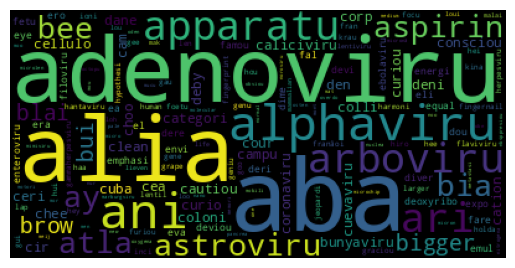

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
word_cloud =WordCloud().generate(' '.join(feature_names_list))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [38]:
data_df.columns

Index(['id', 'title', 'introtext', 'fulltext', 'cat_id', 'class_2', 'level',
       'cat_parent_id', 'parent_title', 'grandparent_id', 'grandparent_title',
       'title_cleaned', 'introtext_cleaned', 'fulltext_cleaned'],
      dtype='object')

In [39]:
bag_nlp_df

,cat_id,cat_parent_id,grandparent_id,abil,abl,abnorm,academi,acceler,access,accord,...,year,yet,yield,young,âin,âit,âour,âthe,âthi,âwe
0,1836,2100,2096,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
1,1836,2100,2096,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
2,1836,2100,2096,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1836,2100,2096,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1836,2100,2096,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9145,2139,2128,2096,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9146,2139,2128,2096,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9147,2139,2128,2096,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9148,2149,2093,2096,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [40]:
bag_nlp_df['kmeans']=results['KMeans']
bag_nlp_df.head()

,cat_id,cat_parent_id,grandparent_id,abil,abl,abnorm,academi,acceler,access,accord,...,yet,yield,young,âin,âit,âour,âthe,âthi,âwe,kmeans
0,1836,2100,2096,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
1,1836,2100,2096,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1836,2100,2096,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1836,2100,2096,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1836,2100,2096,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
bag_nlp_df.to_csv('final_data.csv')

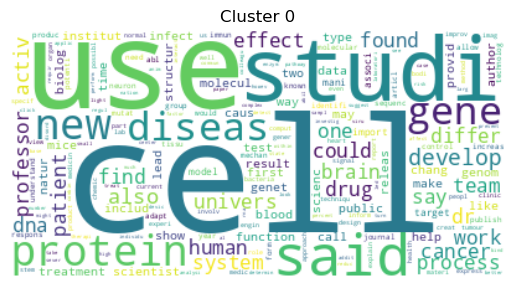

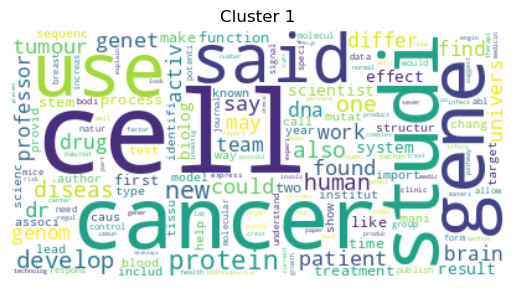

In [42]:
temp = bag_nlp_df.drop(columns=['cat_id', 'level','cat_parent_id','grandparent_id'])
grouped = temp.groupby('kmeans').sum()
for cluster, row in grouped.iterrows():
    words = {}
    for word, value in row.iteritems():
        words[word] = value
    
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(words)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {cluster}")
    plt.show()

In [43]:
bag_nlp_df = pd.concat([data_df[['cat_id','parent_title','grandparent_id']], df_bow_sklearn], axis=1)
bag_nlp_df.shape

(9150, 1178)

In [44]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Assuming data is loaded as `df` and target column is 'target'
# Convert the target to string if they're not
bag_nlp_df['parent_title'] = bag_nlp_df['parent_title'].astype(str)

y = bag_nlp_df['parent_title']
X = bag_nlp_df.drop(columns=['parent_title','cat_id', 'grandparent_id'])

# Count the instances of each class
class_counts = y.value_counts()

# Find the classes that have at least 2 instances
valid_classes = class_counts[class_counts >= 2].index

# Filter the data to only include these classes
y = y[y.isin(valid_classes)]
X = X.loc[y.index]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

# Binarize target for ROC
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)
# Initialize classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier())
]

# Data Collection
metrics_data = []
roc_data = []

# Model Training, Prediction & Metric Calculation
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    report = classification_report(y_test, predictions, output_dict=True, zero_division=1)
    
    # Collecting metrics data
    for target_class in list(set(y_test.values)):
        metrics_data.append((name, target_class, report[target_class]['precision'], report[target_class]['recall'], report[target_class]['f1-score']))
        
    # ROC and AUC for multi-class (One-vs-All approach)
    y_prob = clf.predict_proba(X_test)
    for idx, target_class in enumerate(list(set(y_test.values))):
        fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_prob[:, idx])
        auc = roc_auc_score(y_test_bin[:, idx], y_prob[:, idx])
        roc_data.append((name, target_class, fpr, tpr, auc))
        
# Convert results to DataFrame for visualization
df_metrics = pd.DataFrame(metrics_data, columns=["Classifier", "Class", "Precision", "Recall", "F1-Score"])

# Visualizations
# Bar charts for metrics
fig = px.bar(df_metrics, x="Classifier", y=["Precision", "Recall", "F1-Score"], color="Class", barmode="group", title="Classification Metrics Comparison")
fig.show()

# ROC Curves
fig = go.Figure()
for name, target_class, fpr, tpr, auc in roc_data:
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=f'{name} - Class {target_class} (AUC: {auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Baseline', line=dict(dash='dash')))
fig.update_layout(title="ROC Curve", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate", xaxis=dict(scaleanchor="y", scaleratio=1), yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()


In [45]:
df_metrics

,Classifier,Class,Precision,Recall,F1-Score
0,Logistic Regression,Genomics,0.390244,0.423280,0.406091
1,Logistic Regression,Clinical Research,0.200000,0.145833,0.168675
2,Logistic Regression,Big Data,0.217391,0.142857,0.172414
3,Logistic Regression,Proteomics,0.320312,0.369369,0.343096
4,Logistic Regression,Disease Processes,0.461741,0.471698,0.466667
5,Logistic Regression,Alternative Energy,0.411765,0.350000,0.378378
6,Logistic Regression,Biopollution,0.400000,0.153846,0.222222
7,Logistic Regression,Material Science,0.545455,0.307692,0.393443
8,Logistic Regression,Bio-IT,0.497024,0.520249,0.508371
9,Logistic Regression,Cell Biology,0.355556,0.355556,0.355556


In [46]:
len(y_prob),y_prob[0]

(1830,
 array([0.03, 0.01, 0.14, 0.01, 0.01, 0.02, 0.06, 0.08, 0.19, 0.01, 0.02,
        0.05, 0.15, 0.06, 0.08, 0.06, 0.01, 0.01]))

In [47]:
results

{'KMeans': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'SpectralClustering': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'Hierarchical': array([0, 0, 0, ..., 0, 0, 0]),
 'DBSCAN': array([-1, -1, -1, ..., -1, -1, -1]),
 'HDBSCAN': array([5, 5, 5, ..., 4, 4, 4])}

In [48]:
report

{'Alternative Energy': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 20},
 'Big Data': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35},
 'Bio-IT': {'precision': 0.5342465753424658,
  'recall': 0.6074766355140186,
  'f1-score': 0.5685131195335277,
  'support': 321},
 'Bioengineering': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 27},
 'Biopollution': {'precision': 1.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 13},
 'Cancer Research': {'precision': 0.626984126984127,
  'recall': 0.8777777777777778,
  'f1-score': 0.7314814814814814,
  'support': 180},
 'Cell Biology': {'precision': 0.5,
  'recall': 0.08888888888888889,
  'f1-score': 0.1509433962264151,
  'support': 45},
 'Clinical Research': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 48},
 'Disease Processes': {'precision': 0.4537037037037037,
  'recall': 0.7924528301886793,
  'f1-score': 0.577036310107949,
  'support': 371},
 'Food Bioscience'

In [49]:
metrics_data

[('Logistic Regression',
  'Genomics',
  0.3902439024390244,
  0.42328042328042326,
  0.4060913705583757),
 ('Logistic Regression',
  'Clinical Research',
  0.2,
  0.14583333333333334,
  0.16867469879518074),
 ('Logistic Regression',
  'Big Data',
  0.21739130434782608,
  0.14285714285714285,
  0.17241379310344826),
 ('Logistic Regression',
  'Proteomics',
  0.3203125,
  0.36936936936936937,
  0.34309623430962344),
 ('Logistic Regression',
  'Disease Processes',
  0.46174142480211083,
  0.4716981132075472,
  0.4666666666666667),
 ('Logistic Regression',
  'Alternative Energy',
  0.4117647058823529,
  0.35,
  0.37837837837837834),
 ('Logistic Regression',
  'Biopollution',
  0.4,
  0.15384615384615385,
  0.2222222222222222),
 ('Logistic Regression',
  'Material Science',
  0.5454545454545454,
  0.3076923076923077,
  0.3934426229508197),
 ('Logistic Regression',
  'Bio-IT',
  0.49702380952380953,
  0.5202492211838006,
  0.5083713850837138),
 ('Logistic Regression',
  'Cell Biology',
  0.

In [50]:
bag_nlp_df.parent_title.unique()

array(['Big Data', 'Nanotechnology', 'Alternative Energy', 'Bio-IT',
       'Healthcare Technology', 'Genomics', 'Clinical Research',
       'Disease Processes', 'Cancer Research', 'Bioengineering',
       'Green Biology', 'Proteomics', 'Stem Cells', 'Neuroscience',
       'Material Science', 'Cell Biology', 'Food Bioscience',
       'Biopollution'], dtype=object)

In [51]:
X

,abil,abl,abnorm,academi,acceler,access,accord,account,accumul,accur,...,year,yet,yield,young,âin,âit,âour,âthe,âthi,âwe
0,0,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9146,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9148,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
